In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
pd.options.display.float_format = "{:.4f}".format
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.lines import Line2D
plt.rcParams["figure.figsize"] = (16,10)
# plt.style.use("~/.dracula.mplstyle")
import seaborn as sns
import quandl
import functools, re
import statsmodels.api as sm
from collections import Counter

# QUANDL Config
import os, sys
parent_path = os.path.abspath(os.path.join('..'))
if parent_path not in sys.path:
    sys.path.append(parent_path)
from common.config import QUANDL_API_KEY  # If you are not Philip, you don't have config
                                          # unless you make your own.
from common.functions import portstats_bm

quandl.ApiConfig.api_key = QUANDL_API_KEY # Replace with your API key if running.

In [2]:
START_DATE    = "2009-01-01"
END_DATE      = "2021-12-31"

FX_DB     = "CUR/"
CURRENCIES = ["GBP", "ZAR", "THB", "PKR", "PHP"]
YC_DB = "YC/"
COUNTRIES = ["GBR_ISSC", "GBR", "ZAF", "THA", "PAK", "PHL"]
FF_TABLE      = "F-F_Research_Data_Factors_daily"
FF_DB         = "famafrench"

In [3]:
par_raw = quandl.get([YC_DB + c for c in COUNTRIES], start_date=START_DATE, end_date=END_DATE)
fx_raw = quandl.get([FX_DB + c for c in CURRENCIES], start_date=START_DATE, end_date=END_DATE)

## Clean Data

Map Yield Curve par data into a friendly MultiIndex for future slicing and usage.

In [4]:
def clean_columns(s: str, pre=len(YC_DB)):
    """Takes in Quandl formatted column names...
    returns a list to construct a pd.MultiIndex
    "YC/GBR_ISSC - 0.08Y" -> ['GBR', 0.08]
    """
    mapper = {'0.08Y': 0.08, '3-Month': 0.25, '6-Month': 0.5,
              '9-Month': 0.75, '12-Month': 1, '3to5-Year': 4, '5to10-Year': 7.5, 
              '10-Year': 10, '1-Month': 0.08, '1-Year': 1, '2-Year': 2, '3-Year': 3,
              '4-Year': 4, '5-Year': 5, '6-Year': 6, '7-Year': 7, '8-Year': 8, '9-Year': 9,
              '15-Year': 15, '20-Year': 20, '25-Year':25}
    
    ret = re.split(r"([A-Z]\d{4})|( - )", s[pre:])
    coun = ret[0].split('_')[0]
    ten = mapper[ret[-1]]
    return [coun, ten]

test_col = par_raw.columns[0]
print(f"IN:\n{test_col}\nOUT:\n{clean_columns(test_col)}")

par_raw = pd.concat([par_raw.iloc[:, 0], par_raw.iloc[:, 60:]], axis=1)

par_cols = pd.MultiIndex.from_arrays(
    [[clean_columns(c)[0] for c in par_raw.columns], [clean_columns(c)[1] for c in par_raw.columns]],
    names=("COUNTRY", "TENOR"))

par_raw.columns = par_cols
par_raw = par_raw / 100

fx_raw.columns = [c[4:].split(" - ")[0] for c in fx_raw.columns]

IN:
YC/GBR_ISSC - 0.08Y
OUT:
['GBR', 0.08]


## South Africa is missing 5 Year

Fill it in using interp so the carry strategy has as 5-yr to trade.

In [5]:
fives = []

for d, row in par_raw["ZAF"].iterrows():
    five = np.interp(5, row.index.values, row.values)
    fives.append(five)
    
par_raw[("ZAF", 5.0)] = fives

## Turn `Spot Rates` to `Zero Rates`

To discount coupons from off-the-run bond cash flows. Under a stochastic interest rate model, we assume each time in the future has a different discount rate. Therefore, it is important to generate an interest rate term structure that is flexible and allows the dynamic pricing of cash flows at different times in the future.

In [6]:
def compute_zcb_curve(spot_rates_curve):
    zcb_rates = spot_rates_curve.copy()
    for curve in spot_rates_curve.columns:
        spot = spot_rates_curve[curve].dropna()
        for tenor, spot_rate in spot.iteritems():
            if tenor>0.001:
                pmt = 0.25
                times = np.arange(tenor-pmt, 0, step=-pmt)[::-1]
                coupon = pmt*spot_rate
                z = np.interp(times, zcb_rates[curve].dropna().index.values, zcb_rates[curve].dropna().values) # Linear interpolation
                preceding_coupons_val = (coupon*np.exp(-z*times)).sum()
                zcb_rates[curve][tenor] = -np.log((1-preceding_coupons_val)/(1+coupon))/tenor
    return zcb_rates

cou = par_raw.resample("W-Wed").last()
cou = cou.ffill().where(cou.bfill().notna()) #.interpolate(method="ffill", limit_area="inside")
zeros = []

for d, row in cou.iterrows():
    df = row.reset_index().pivot(index="TENOR", columns="COUNTRY").droplevel(None, axis=1)
    zero = compute_zcb_curve(df)
    zero = zero.stack().swaplevel(0,1,0)
    zeros.append(zero)

zeros = pd.concat(zeros, axis=1).T#.interpolate(method="ffill", limit_area="inside")
zeros = zeros.ffill().where(zeros.bfill().notna())
zeros.index = cou.index

## Visualize Important Curves

We examine a time series of `1, 3-month, 5, 10, 20-year` yield curves to understand the dynamics of coupon rates. Increases in 5-year yield should correspond to losses in carry; decreases in yield should lead to profits in carry.

A detailed examination of the charts reveals data quality issues. The dataset has already been forward filled, yet some curves exhibit anomalies. For Thailand (`THL`), a spike in rates in early 2016 leads to substantial drawdown. Pakistan's (`PAK`) yields move in discrete jumps, resulting in sustained periods of making constant gains accompanied by significant tail events. 

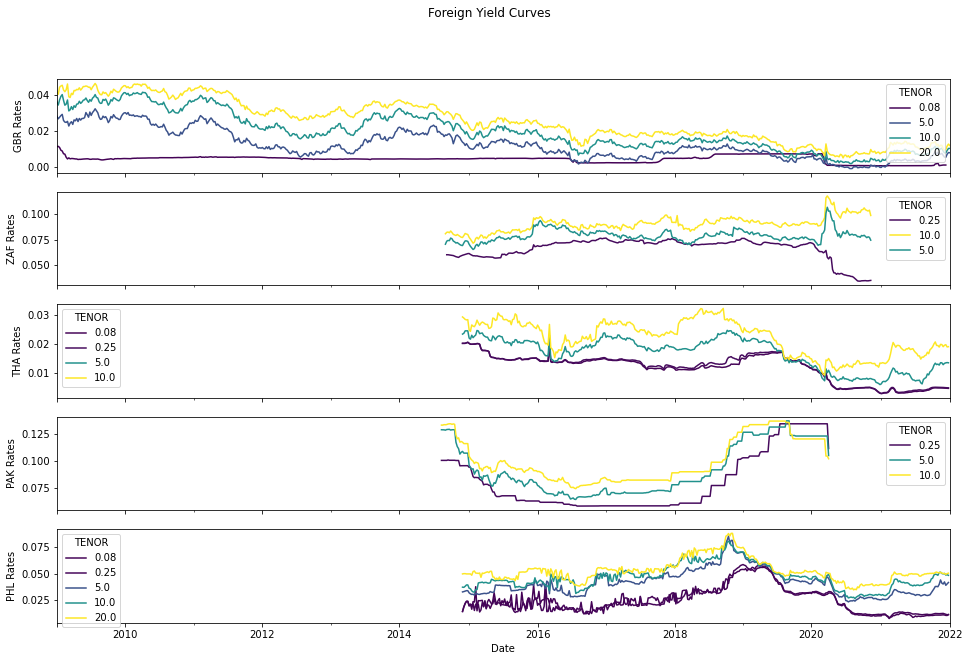

In [7]:
curr = cou.columns.get_level_values(0).unique()
fig, axs = plt.subplots(len(curr), sharex=True)

for i, c in enumerate(curr):
    to_plot = cou[c]
    to_plot = to_plot[[c for c in to_plot.columns if c in [0.08, 0.25, 5, 10, 20]]]
    to_plot.plot(ax=axs[i], color=cm.viridis(to_plot.columns / max(to_plot.columns)))
    axs[i].set_ylabel(f"{c} Rates")
    
plt.suptitle("Foreign Yield Curves")
plt.show()

## Align FX DataFrame

And rename it to follow Yield Curve naming conventions.

In [8]:
fx_raw.columns = pd.MultiIndex.from_arrays([np.array(COUNTRIES[1:]), np.zeros(len(COUNTRIES[1:]))], 
                                           names=("COUNTRY", "TENOR"))

fx = fx_raw.resample("W-Wed").last()

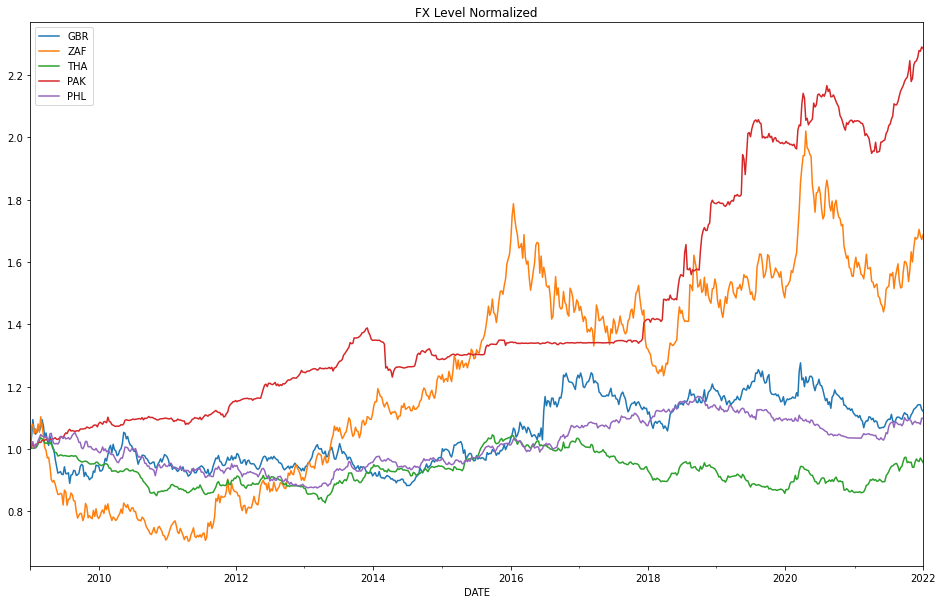

In [9]:
to_plot = fx
to_plot /= to_plot.iloc[0,:]
to_plot.plot()
plt.legend(COUNTRIES[1:])
plt.title("FX Level Normalized")
plt.show()

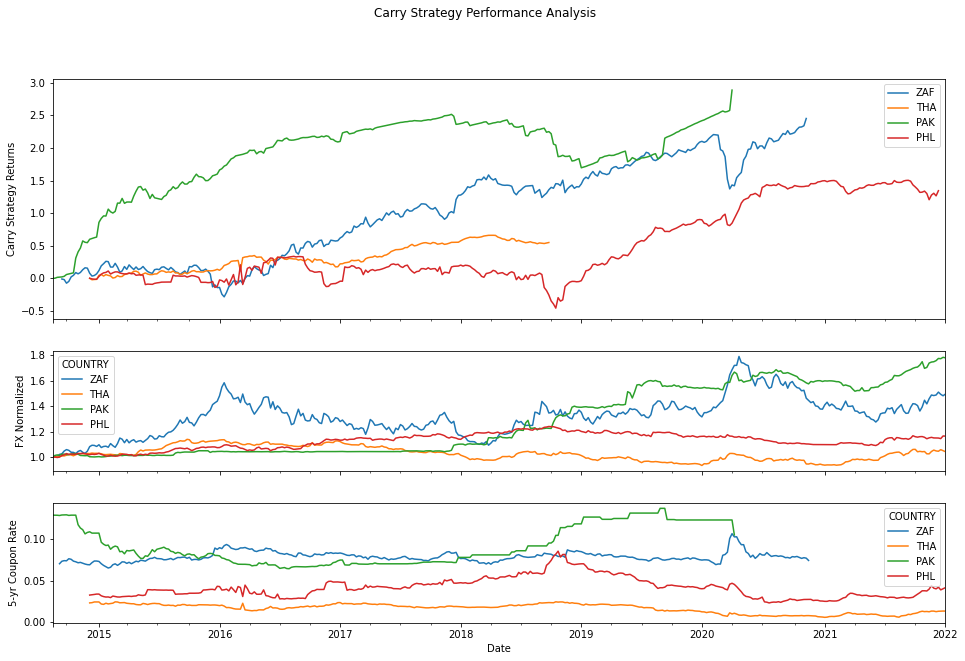

In [10]:
class FXCarry:
    
    def __init__(self, cou: pd.DataFrame, zeros: pd.DataFrame, 
                 fx: pd.DataFrame, lend: list):
        """Evaluates the profitability of holding a foreign bond with
        adjustments to FX rates and leverage.
        lend: list contains the names of the countries in which the strategy lends
        """
        self.strat = pd.concat([cou.shift(1), zeros], axis=1, keys=["COU", "ZER"])
        self.strat.columns.names = ["TYPE", "COUNTRY", "TENOR"]
        self.premium = 0.005 # 50bp
        self.freq = 1/52 # weekly funding
        self.funding = (cou[("GBR", 0.08)] + self.premium) * self.freq
        self.fx = fx
        self.lend = lend
        self.equity = 2e6
        self.leverage = 5
        self.notional = self.equity * self.leverage
        self.long_tenor = 5 # Sell 5 year bonds
        self.fx_ret = self.fx_return(self.fx, self.leverage)
        self.bond_ret = self.value_carry(self.strat)
        self.lev_ret = self.leverage_adj(self.bond_ret, self.leverage)
        self.interest = self.accrue_interest(self.leverage, self.funding)
        self.halt = self.trade_halt(self.strat)
        self.adj_ret = self.fx_fund_adj(self.lev_ret, self.fx_ret[self.lend], 
                                        self.interest, self.halt)
    
    def accrue_interest(self, lev, fund):
        """OIS + premium"""
        pct_lev = (lev - 1) / lev
        return fund * pct_lev
        
    def value_carry(self, strat):
        """Iterates through trading dates and foreign bonds"""
        exits = {l: [] for l in self.lend}
        for d, row in strat.iterrows():
            countries = row.index.get_level_values(1)
            for l in self.lend:
                # row contains all countries. Filter for each lending country
                r = row[countries==l]
                if r.isna().any(): exits[l].append(np.nan)
                else: exits[l].append(self.value_bond(r))
        return pd.DataFrame(exits, index=self.strat.index)
    
    def value_bond(self, row, elapse=1/52):
        """Computes the value of off-the-run bonds. Uses Zero rates
        to determine the present value of each cashflow"""
        pmt = 0.25
        df = row.rename("RATE").reset_index()
        zeros = df.loc[df["TYPE"]=="ZER", ["TENOR", "RATE"]]
        rate = df.loc[(df["TYPE"]=="COU") & (df["TENOR"]==self.long_tenor), "RATE"].values[0]
        coupon = rate / 4 # quarterly payments
        times = np.arange(self.long_tenor-elapse, 0, step=-pmt)[::-1]
        zero_interp = np.interp(times, zeros["TENOR"], zeros["RATE"])
        value = (coupon * np.exp(-zero_interp * times)).sum() + np.exp(-zero_interp[-1] * times[-1])
        return value
    
    def leverage_adj(self, ret, leverage):
        return (ret - 1) * leverage + 1
    
    def fx_return(self, fx, leverage):
        """Computes FX return using level and adjusts charges based on leverage"""
        return fx.shift(1).bfill() / fx#(fx.shift(1).bfill() / fx - 1) / leverage + 1
    
    def trade_halt(self, strat):
        mask = (strat.columns.get_level_values(0)=="COU") 
        mask &=(strat.columns.get_level_values(2)==5)

        temp = strat.loc[:,mask]
        temp.columns = temp.columns.droplevel(["TYPE", "TENOR"])
        return temp.iloc[:, 1:].gt(temp["GBR"]+0.005, axis=0).astype(int)
    
    def fx_fund_adj(self, lev_ret, fx_ret, interest, halt):
        """As USD Investors, adjust returns based on FX rate changes and funding interest"""
        return (((lev_ret-1) * halt[lev_ret.columns] + 1) * fx_ret.values).subtract(interest, axis=0)
        
    def display_perf(self):
        fig, axs = plt.subplots(3, gridspec_kw={"height_ratios": [8,4,4]}, sharex=True)
        first = self.adj_ret.dropna(how="all").index[0]
        perf = ((self.adj_ret-1)).cumsum().loc[first:,:][self.lend]
        perf.plot(ax=axs[0])
        axs[0].set_ylabel("Carry Strategy Returns")
        fx = (self.fx / self.fx.loc[first,:]).swaplevel(0,1,1)[0].loc[first:,:][self.lend]
        fx.plot(ax=axs[1])
        axs[1].set_ylabel("FX Normalized")
        cou = self.strat.swaplevel(1,2,1)["COU"][self.long_tenor].loc[first:,:][self.lend]
        axs[2].set_ylabel(f"{self.long_tenor}-yr Coupon Rate")
        cou.plot(ax=axs[2])
        plt.suptitle("Carry Strategy Performance Analysis")
        plt.show()



lend = COUNTRIES[2:]

carry = FXCarry(cou, zeros, fx, lend)
carry.display_perf()

## Performance Analysis

The above chart depicts `strategy returns`, `FX`, and `Coupon Rates`. The colors correspond with specific countries across plots. Most apparently with `PAK` (green), the carry stategy makes significant gains as the `Coupon Rate` decreases and vice versa. `ZAF` clearly illustrates losses and gains driven by changes in FX rate. Overall, the strategy behaves as a combination of the change in coupon rate, FX returns, and a 1 week carry.

Compare with Factors, FX Rates, and Yields to determine what drives the strategy.

In [11]:
ff_raw = pdr.data.DataReader(FF_TABLE, FF_DB, START_DATE, END_DATE)

f_ret = np.log(ff_raw[0] / 100 + 1)
f_ret.index.name = "date"
f_level = np.exp(f_ret.cumsum())

ff = f_ret.resample("W-Wed").sum().drop(columns="RF")

## Fama French Decomposition

All four strategies involving `ZAF`, `THA`, `PAK`, and `PHL` appear uncorrelated with the Fama French factors. $R^2$ levels fail to indicate signficance; the regression intercept alpha accounts for a significant positive portion of return. This behavior is expected because the carry trade exploits a different way of generating returns on the market: i.e. lending to countries with higher credit risk and capitalizing on higher yields while assuming the risk that the exchange rate may move unfavorably.

The strategy described in the problem statement asks to invest in the same notional amount without reinvesting profits. However, it should be noted that in the calculation of mean and standard deviation, profits are accumulated.

`ZAF` and `PAK` notably accomplished incredible leveraged returns with accompanying substantial drawdowns. Both had impressive Sharpe Ratios and excess return. `THA` and `PHL` returns were impressive, yet less stellar compared with the other two pairs. However, `THA` exhibited significantly less drawdown and volatility compared with other pairs. From an investment persepctive, adding the `THA` carry trade may benefit a portfolio's variance while not substantially sacrificing return.

All `5x` leveraged positions assume substantial risk when the lending country's coupon rates are increasing. This strategy only prevents trading when the borrowing currency's corresponding yield + 50bp is higher than the yield of the lending currency. This requirement does not adaquately filter trades, and this carry strategy will significanly benefit from developing a way to prevent trading in rising interest rate environments.

In [12]:
factor_decomp = []

for c in carry.adj_ret.columns:
    strat = carry.adj_ret[[c]].dropna()-1
    sd, ed = strat.index[0], strat.index[-1]
    res, reg = portstats_bm(strat, ff.loc[sd:ed,:], 52)
    factor_decomp.append(res)

pd.concat(factor_decomp)

,mean,std,sharpe,alpha,beta_Mkt-RF,beta_SMB,beta_HML,r2,mae,treynor,info ratio,drawdown,peak,trough,recovery
ZAF,0.3962,0.3977,0.9964,0.2745,0.9271,0.0113,-0.2237,0.1474,0.2745,0.4274,0.7476,-0.6170,2020-02-05,2020-03-25,2020-11-11
THA,0.1431,0.1847,0.7748,0.1248,0.0990,-0.4466,-0.3719,0.0618,0.1248,1.4454,0.6975,-0.1681,2016-04-20,2016-12-21,2017-05-31
PAK,0.5111,0.3371,1.5163,0.4639,0.2802,-0.1045,-0.3046,0.0185,0.4639,1.8244,1.3890,-0.5939,2017-12-06,2019-01-02,2020-04-01
PHL,0.1905,0.3608,0.5279,0.1817,0.0233,0.0281,-0.1047,0.0016,0.1817,8.1715,0.5040,-0.6066,2016-08-17,2018-10-17,2019-06-19


## Bond and FX Decompositon

The carry strategy's returns are expectly significantly decomposed by the lending bond's weekly returns and the FX returns. The relationship is nearly perfectly illustrated with highly significant $R^2$.

In [13]:
rate_fx_decomp = []
rate_fx = pd.concat([carry.bond_ret-1, carry.fx_ret.droplevel("TENOR", axis=1)-1], 
                    keys=["RATE", "FX"], axis=1)

for c in carry.adj_ret.columns:
    strat = carry.adj_ret[[c]].dropna() -1
    sd, ed = strat.index[0], strat.index[-1]
    bm = rate_fx.swaplevel(0,1,1)[c]
    res, reg = portstats_bm(strat, bm.loc[sd:ed,:], 52)
    rate_fx_decomp.append(res)

rate_fx_decomp = pd.concat(rate_fx_decomp)
rate_fx_decomp[["alpha"] + [c for c in rate_fx_decomp.columns if "beta" in c]+["r2"]]

,alpha,beta_RATE,beta_FX,r2
ZAF,0.0221,4.9259,1.0148,0.9996
THA,-0.0064,5.0214,0.9977,1.0000
PAK,-0.0005,4.9428,0.9909,0.9997
PHL,-0.0054,4.9942,1.0054,1.0000


## Market Volatility Decomposition

`MKT_VOL` represents the volatility of the market during the week of holding the bond. `CALL` is a factor that replicates the return of ATM call options on the market. `PUT` is a factor that replicates the return of ATM put options on the market.

Most carry trade returns act as long call and short put option strategies. Perhaps this relationship indicates a connection between option returns and the movement of FX rates. Although market volatility has a large regression coefficient, it is not significant as weekly return is typically in the order of 1e-2, implying that the large coefficients are balancing the size of a smaller regressor.

In conclusion, we can conclude that the carry strategy has little correlation to market volatility, and what does is driven by the relationship between FX and option pricing.

In [14]:
vol_decomp = []

mkt_vol = pd.DataFrame()
mkt_vol["MKT"] = ff["Mkt-RF"]
mkt_vol["MKT_VOL"] = ff["Mkt-RF"]**2
mkt_vol["CALL"] = ff["Mkt-RF"] * (ff["Mkt-RF"] > 0).astype(int)
mkt_vol["PUT"] = ff["Mkt-RF"] * (ff["Mkt-RF"] < 0).astype(int)

for c in carry.adj_ret.columns:
    strat = carry.adj_ret[[c]].dropna()-1
    sd, ed = strat.index[0], strat.index[-1]
    res, reg = portstats_bm(strat, mkt_vol.loc[sd:ed,:], 52)
    vol_decomp.append(res)

vol_decomp = pd.concat(vol_decomp)
vol_decomp[["alpha"] + [c for c in vol_decomp.columns if "beta" in c]+["r2"]]

,alpha,beta_MKT,beta_MKT_VOL,beta_CALL,beta_PUT,r2
ZAF,0.0552,0.4151,-13.3024,1.0108,-0.5957,0.1918
THA,-0.0581,-0.0292,-12.8141,0.6071,-0.6363,0.0112
PAK,0.4976,0.1627,0.6328,0.0622,0.1005,0.0106
PHL,-0.3547,-0.0551,-9.8775,1.0011,-1.0562,0.0289


## Correlation Analysis

We observe low correlations between the each carry strategy and other carry strategies. Furthermore, they appear relatively uncorrelated with factors and even foreign exchange rates.

Notably, the strategy is highly correlated with the weekly returns of holding the bond for a week. This observation is rather unsurprising as the gains made by carrying the bond for a week is a substantial part of how carry trades make money.

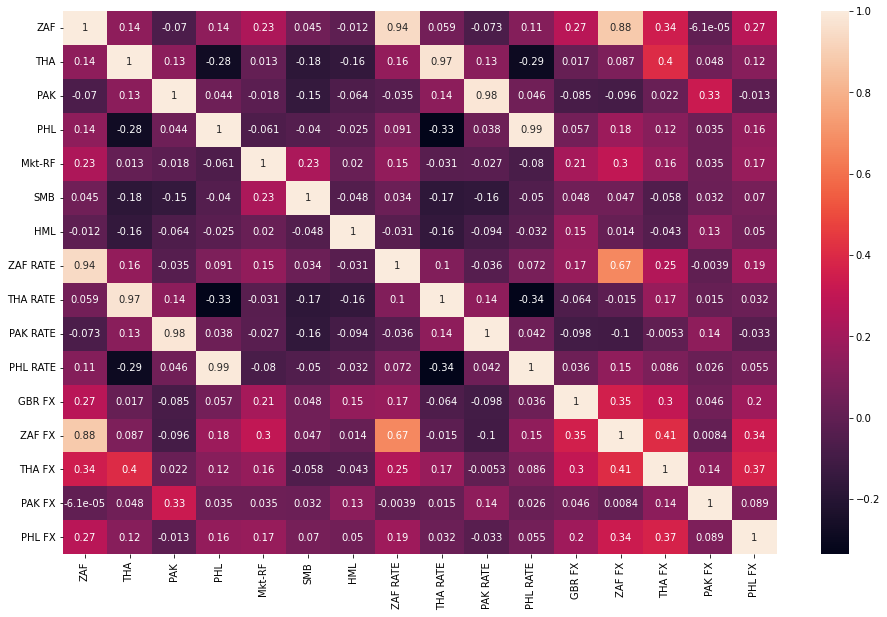

The pair with the HIGHEST correlation is ('PHL RATE', 'PHL') at 0.9946
The pair with the LOWEST  correlation is ('THA RATE', 'PHL RATE') at -0.3364


In [15]:
def disp_corr(df):
    c = df.corr()
    sns.heatmap(c, annot=True); plt.show()
    
    cu = c.unstack().sort_values(ascending=False)
    cu = cu[c.shape[0]:] # There are c.shape[0] 1's in the corr matrix. Skip them.

    print(f"The pair with the HIGHEST correlation is {cu.idxmax()} at {cu.max():.4f}")
    print(f"The pair with the LOWEST  correlation is {cu.idxmin()} at {cu.min():.4f}")


carr = carry.adj_ret.dropna()-1
ffs = ff.loc[carr.index[0]:carr.index[-1],:]
rate_fx.columns = [f"{c[1]} {c[0]}" for c in rate_fx.columns]
rate_fx = rate_fx.loc[carr.index[0]:carr.index[-1],:]

consolidated = pd.concat([carr, ffs, rate_fx], axis=1)

disp_corr(consolidated)

## Breaking Down Returns

For `ZAF`, `THA`, and `PAK`, weekly bond carry returns are the driving force behind the carry trade's returns. The impact of the FX rate varys in degree, depending on whether the exchange rate moved favorably during the period of trading. Interest consistently contributes negatively at a minute degree.

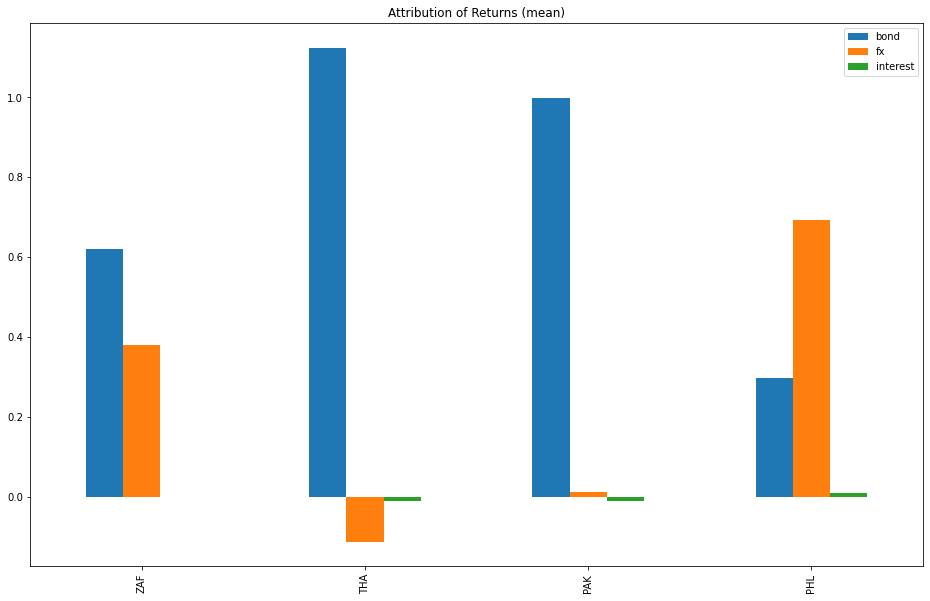

In [16]:
rate_fx = pd.concat([carry.bond_ret-1, carry.fx_ret.droplevel("TENOR", axis=1)-1], 
                    keys=["RATE", "FX"], axis=1)

return_decomp = {}

for i, c in enumerate(carry.adj_ret.columns):
    strat = carry.adj_ret[c].dropna()-1
    sd, ed = strat.index[0], strat.index[-1]
    lr = carry.lev_ret.loc[sd:ed,c]-1
    fr = carry.fx_ret.droplevel("TENOR", axis=1).loc[sd:ed,c]-1
    lr = (lr / strat)
    fr = (fr / strat)
    ir = 1 - lr - fr
    return_decomp[c] = (lr.mean(), fr.mean(), ir.mean())

return_decomp = pd.DataFrame(return_decomp, index=["bond", "fx", "interest"])#.T

fig, ax = plt.subplots()

p = return_decomp.T.plot.bar(ax=ax)
plt.title("Attribution of Returns (mean)")
plt.show()